In [49]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import networkx as nx
import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time
import joblib
from joblib import Parallel, delayed

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.2.0
pandas 1.3.5
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1


# Neuropixels data. <a name='data'></a>

In [3]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Download time: 720000


In [4]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

### Neurons Selection

In [5]:
probes = ['probeC', 'probeD', 'probeE'] # ['probeC', 'probeE']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())

probeC    94
probeE    89
probeD    78
Name: probe_description, dtype: int64

261

#### Fine Time Coupling Model

In [6]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
jittertool = jitter.JitterTool()

## Trials Selection

In [118]:
# condition_ids = [251, 255, 261, 270, 278]  # x5  7913
# condition_ids = [251, 255, 261, 270, 278, 284] # x6  7913
# condition_ids = [278, 270, 255, 253, 262, 251, 258, 246, 263, 275, 247, 273]  # x12  7913

# condition_ids = [275, 268, 270, 284, 274, 249, 263, 261,
#                  278, 267, 280, 256, 260, 257, 281]  # x15 7989
# condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261,
#                  286, 258, 278, 267, 280, 256, 260, 257, 281]  # x19  7989
# condition_ids = [268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x12 7989

In [7]:
# condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
condition_ids = [275, 246, 268, 270,]

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
model.print_conditions(trials_groups)

0  246 temp freq [15.0] orient [0.0] contrast [0.8] [ 3798  3852  3947  3966  3979 31016 31026 31160 31186 49206 49245 49346 49372 49409 49412]
1  268 temp freq [4.0] orient [45.0] contrast [0.8] [ 3833  3882  3884  3899  3951  3988 31040 31086 31089 31116 31149 31197 49255 49277 49327]
2  270 temp freq [8.0] orient [45.0] contrast [0.8] [ 3835  3898  3914  3934 31062 31104 31114 49250 49274 49281 49286 49304 49322 49415 49422]
3  275 temp freq [8.0] orient [0.0] contrast [0.8] [ 3855  3860  3938 31004 31072 31081 31105 31135 31200 49231 49299 49316 49389 49399 49427]
total num trials: 60


## Spike Trains

In [8]:
trial_window = [0.4, 2.0]

# dt=0.002
# spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)
# spike_trains = model.get_trial_metric_per_unit_per_trial(
#     stimulus_presentation_ids=all_trials_indices,
#     unit_ids=selected_units.index.values,
#     trial_time_window=trial_time_window,
#     metric_type='spike_trains', dt=dt)
# spike_counts = model.get_trial_metric_per_unit_per_trial(
#         stimulus_presentation_ids=all_trials_indices,
#         unit_ids=selected_units.index.values,
#         trial_time_window=trial_time_window,
#         metric_type='count', empty_fill=0)
spike_times = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_window,
        metric_type='spike_times')


In [9]:
# display(spike_trains.shape)
# display(spike_trains.iloc[0,0].shape)
display(spike_times.shape)
# display(spike_times.head())

(261, 60)

# Fit individual filter + raw filter clustering.

In [10]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeC', 'probeD', 'probeE'], num_areas=3, verbose=False)

conditions: [(0, 246), (1, 268), (2, 270), (3, 275)]


In [33]:
# a = stimulus_table['stimulus_condition_id'].unique(); b = np.setdiff1d(a,select_condition_ids)
# [247, 248, 250, 251, 252, 253, 254, 255, 259, 262, 264, 266, 269, 271, 272, 276, 277, 279, 282, 283, 285]
# select_condition_ids = [275, 246, 268, 270, 284, 274,  249, 263, 265, 261, 286, 258,  278, 267, 280, 256, 260, 257, 281]
select_condition_ids = [275, 246, 268, 270,]

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)

[ 3798  3833  3835  3852  3855  3860  3882  3884  3898  3899  3914  3934  3938  3947  3951  3966  3979  3988
 31004 31016 31026 31040 31062 31072 31081 31086 31089 31104 31105 31114 31116 31135 31149 31160 31186 31197
 31200 49206 49231 49245 49250 49255 49274 49277 49281 49286 49299 49304 49316 49322 49327 49346 49372 49389
 49399 49409 49412 49415 49422 49427]


### Within probes.

In [18]:
active_firing_rate_quantile_threshold = 0.7
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=False)
probe_pairs = [('probeE', 'probeC')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_probe = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids, random_val=False)

num_pairs: 756


In [196]:
model_par = {'filter_type': 'bspline', 'num_knots': 5, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.8, 'max_num_itrs': 40, 'epsilon': 1e-5}
model_list = model.each_pair_all_trials_bivariate_regression(filter_membership_probe, 'neuron', model_par, group_ids=[0], verbose=False)

100%|█████████████████████████████████████████████████████████████| 756/756 [06:21<00:00,  1.98it/s]


In [197]:
file_path = project_dir + 'Output/fig/AL_V1_within_probe_alltrials_filter.pdf'
model.plot_model_list_checkerboard(model_list, file_path=None)

Save figure to: D:/Brain_Network/Output/fig/AL_V1_within_probe_alltrials_filter.pdf


### Between probes.

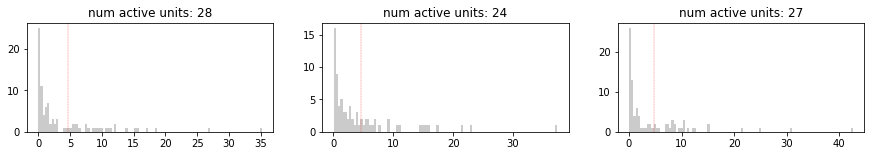

num_pairs: 672
num_pairs: 648


In [58]:
active_firing_rate_quantile_threshold = 0.7
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)

probe_pairs = [('probeC', 'probeD')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_CD = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids, random_val=True)

probe_pairs = [('probeD', 'probeE')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_DE = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids, random_val=True)

  0%|                                                                      | 0/1320 [00:00<?, ?it/s]layers 2, nodes 1, trials 60
meanFR 9.658	meanISI 13.051


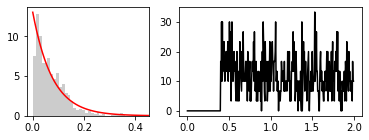

layers 2, nodes 1, trials 60
meanFR 6.267	meanISI 10.073
  0%|                                                                      | 0/1320 [01:44<?, ?it/s]


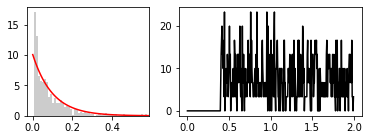

(951102646, 951108540)


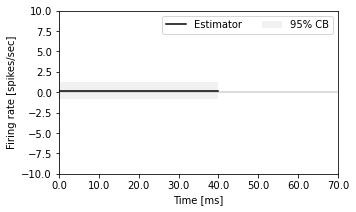

  0%|                                                              | 1/1320 [00:01<24:12,  1.10s/it]layers 2, nodes 1, trials 60
meanFR 9.658	meanISI 13.051


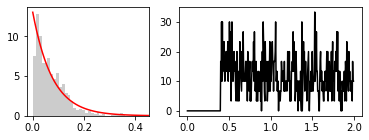

layers 2, nodes 1, trials 60
meanFR 11.575	meanISI 18.485


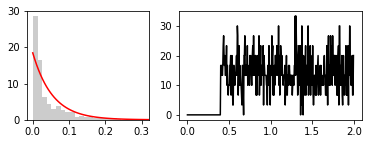

(951102646, 951108557)


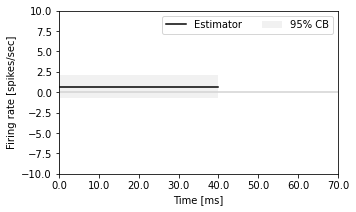

  0%|                                                              | 2/1320 [00:02<24:28,  1.11s/it]layers 2, nodes 1, trials 60
meanFR 9.658	meanISI 13.051


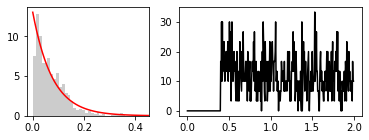

layers 2, nodes 1, trials 60
meanFR 11.742	meanISI 16.033


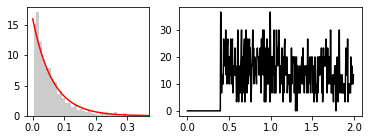

(951102646, 951108685)


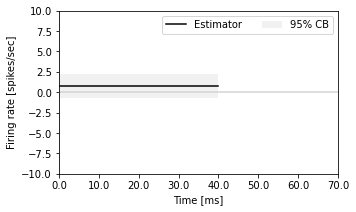

  0%|▏                                                             | 3/1320 [00:03<24:01,  1.09s/it]layers 2, nodes 1, trials 60
meanFR 9.658	meanISI 13.051


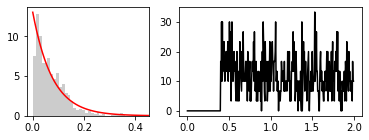

layers 2, nodes 1, trials 60
meanFR 7.375	meanISI 10.732


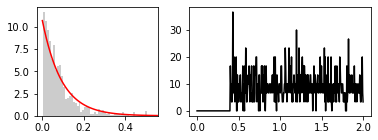

(951102646, 951108721)


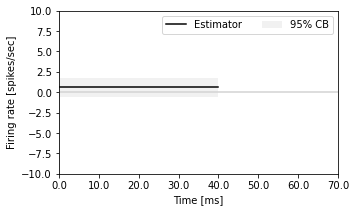

  0%|▏                                                             | 4/1320 [00:04<23:51,  1.09s/it]layers 2, nodes 1, trials 60
meanFR 9.658	meanISI 13.051


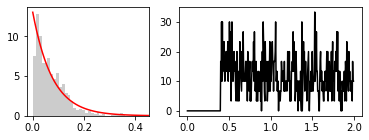

layers 2, nodes 1, trials 60
meanFR 8.708	meanISI 15.409


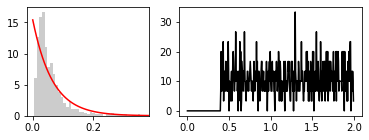

(951102646, 951108867)


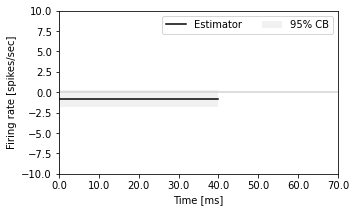

  0%|▏                                                             | 5/1320 [00:05<22:57,  1.05s/it]layers 2, nodes 1, trials 60
meanFR 9.658	meanISI 13.051


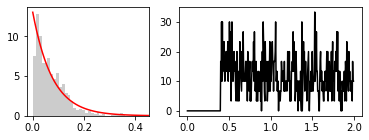

layers 2, nodes 1, trials 60
meanFR 5.683	meanISI 9.488


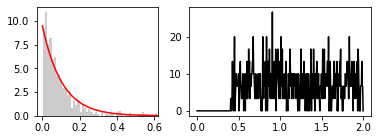

(951102646, 951110003)


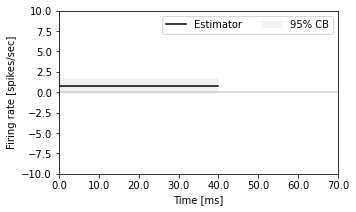

  0%|▎                                                             | 6/1320 [00:06<22:19,  1.02s/it]layers 2, nodes 1, trials 60
meanFR 9.658	meanISI 13.051


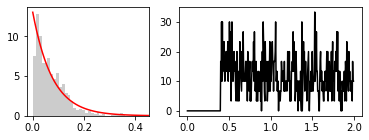

layers 2, nodes 1, trials 60
meanFR 12.475	meanISI 16.972


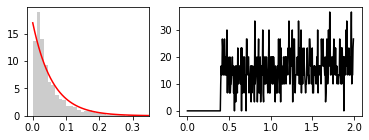

(951102646, 951108877)


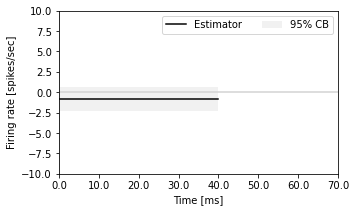

  1%|▎                                                             | 7/1320 [00:07<22:57,  1.05s/it]layers 2, nodes 1, trials 60
meanFR 9.658	meanISI 13.051


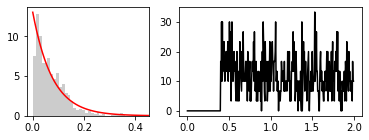

layers 2, nodes 1, trials 60
meanFR 13.958	meanISI 19.005


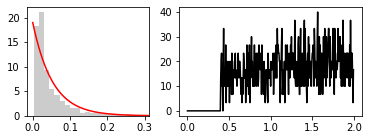

(951102646, 951108911)


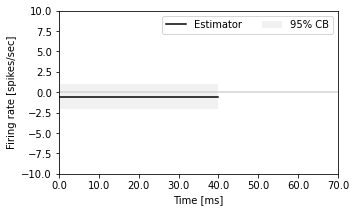

  1%|▍                                                             | 8/1320 [00:08<23:10,  1.06s/it]layers 2, nodes 1, trials 60
meanFR 9.658	meanISI 13.051


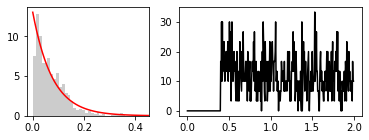

layers 2, nodes 1, trials 60
meanFR 7.417	meanISI 10.39


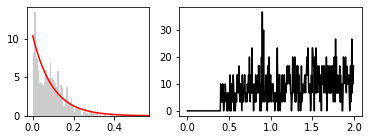

(951102646, 951109184)


KeyboardInterrupt: 

<Figure size 360x216 with 0 Axes>

In [73]:
# neuron_pairs = [(951103332, 951109435), (951103332, 951109137), (951103332, 951109118)]
filter_membership_joint = filter_membership_CD.append(filter_membership_DE)
# model_par = {'filter_type': 'bspline', 'num_knots': 8, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 60, 'epsilon': 1e-5}

model_par = {'filter_type': 'square', 'filter_length': 0.04,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 60, 'epsilon': 1e-5}

model_list = model.pairwise_bivariate_regression(filter_membership_joint, model_par, verbose=True)

#### Select the smoothing kernel width using plug-in estimator (with sub-sampling).

#all trials:71497	#batch trials:3000
optimal kernel width  60.0


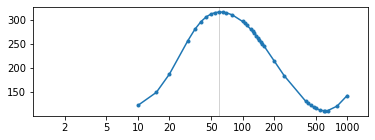

optimal kernel width  40.0


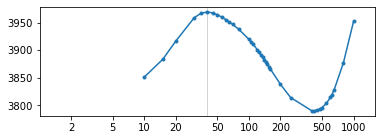

optimal kernel width  70.0


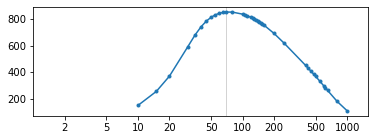

optimal kernel width  55.0


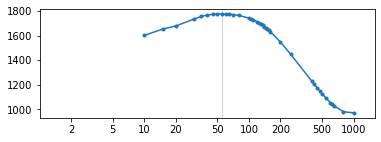

optimal kernel width  10.0


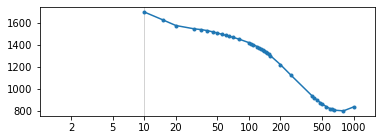

In [64]:
model.estimate_nuisance_kernel_width_by_group(filter_membership_joint)

# KS test --  goodness-of-fit test

In [2004]:
# for i, (neuron_x, neuron_y) in enumerate(filter_membership_DE.index):
#     if neuron_x % 3 == 0 and neuron_y % 3 == 0:
#         print(i, neuron_x, neuron_y)
for i, (neuron_x, neuron_y) in enumerate(filter_membership_CD.index):
    if neuron_x % 3 == 0 and neuron_y % 3 == 0:
        print(i, neuron_x, neuron_y)

240 951103290 951108540
244 951103290 951108867
250 951103290 951109137
253 951103290 951109191
255 951103290 951109299
258 951103290 951109338
259 951103290 951109329
312 951103332 951108540
316 951103332 951108867
322 951103332 951109137
325 951103332 951109191
327 951103332 951109299
330 951103332 951109338
331 951103332 951109329
336 951103380 951108540
340 951103380 951108867
346 951103380 951109137
349 951103380 951109191
351 951103380 951109299
354 951103380 951109338
355 951103380 951109329
384 951103488 951108540
388 951103488 951108867
394 951103488 951109137
397 951103488 951109191
399 951103488 951109299
402 951103488 951109338
403 951103488 951109329
408 951103530 951108540
412 951103530 951108867
418 951103530 951109137
421 951103530 951109191
423 951103530 951109299
426 951103530 951109338
427 951103530 951109329
432 951103632 951108540
436 951103632 951108867
442 951103632 951109137
445 951103632 951109191
447 951103632 951109299
450 951103632 951109338
451 951103632 95

240 951103290 951108540


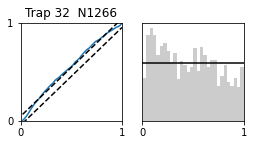

244 951103290 951108867


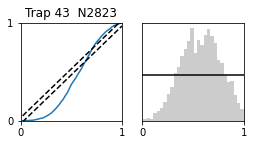

250 951103290 951109137


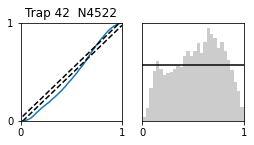

253 951103290 951109191


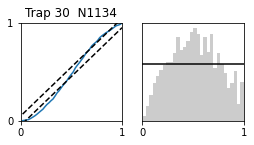

255 951103290 951109299


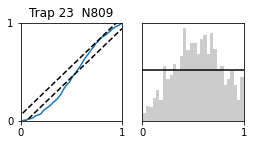

258 951103290 951109338


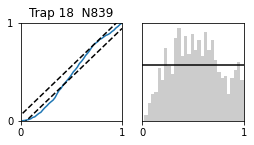

259 951103290 951109329


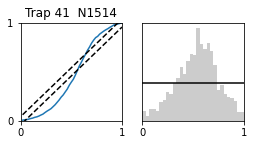

312 951103332 951108540


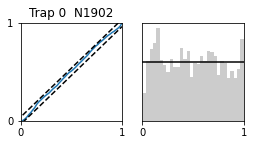

316 951103332 951108867


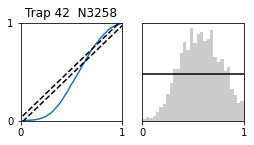

322 951103332 951109137


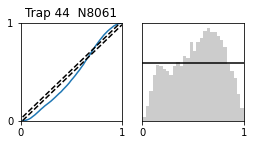

325 951103332 951109191


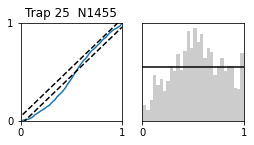

327 951103332 951109299


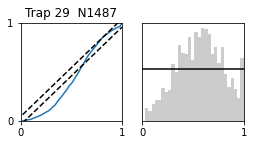

330 951103332 951109338


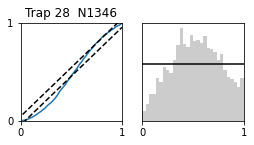

331 951103332 951109329


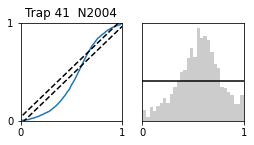

336 951103380 951108540


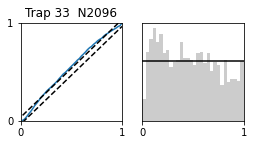

340 951103380 951108867


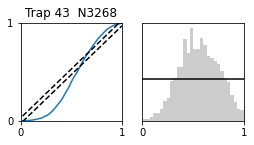

346 951103380 951109137


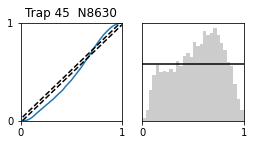

349 951103380 951109191


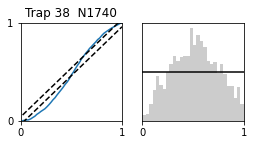

351 951103380 951109299


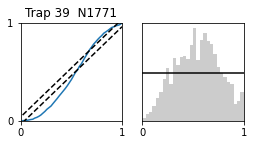

354 951103380 951109338


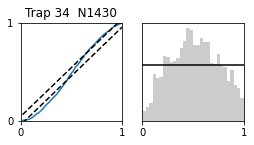

355 951103380 951109329


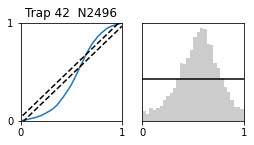

384 951103488 951108540


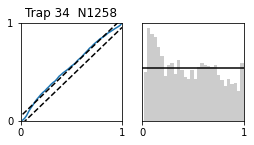

388 951103488 951108867


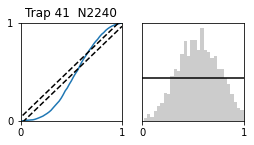

394 951103488 951109137


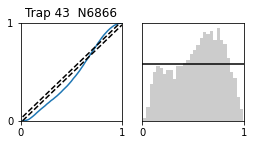

397 951103488 951109191


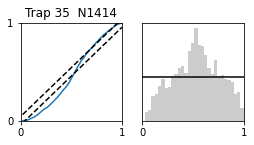

399 951103488 951109299


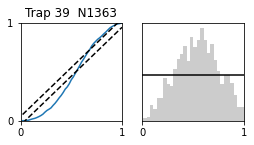

402 951103488 951109338


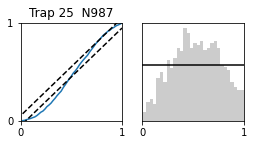

403 951103488 951109329


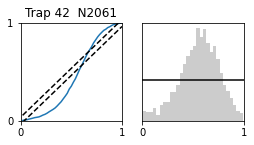

408 951103530 951108540


D:/Brain_Network/Code\jitter.py:4068: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4070: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4095: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
D:/Brain_Network/Code\jitter.py:8267: RuntimeWarning: invalid value encountered in matmul
  lambda_hat = X @ beta


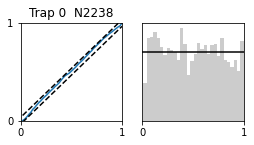

412 951103530 951108867


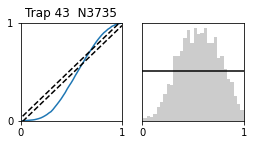

418 951103530 951109137


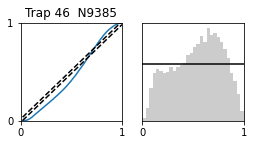

421 951103530 951109191


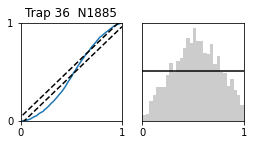

423 951103530 951109299


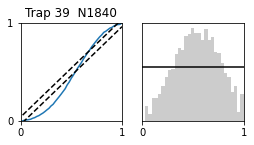

426 951103530 951109338


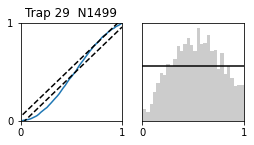

427 951103530 951109329


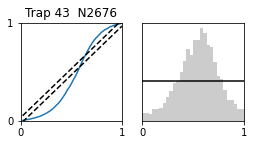

432 951103632 951108540


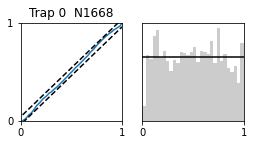

436 951103632 951108867


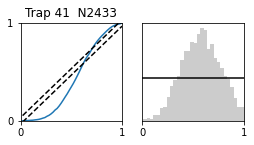

442 951103632 951109137


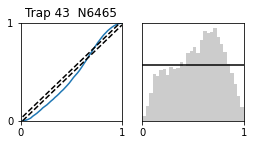

445 951103632 951109191


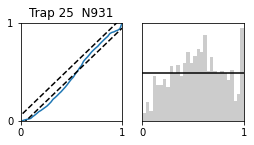

447 951103632 951109299


D:/Brain_Network/Code\jitter.py:4068: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4070: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4095: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
D:/Brain_Network/Code\jitter.py:8267: RuntimeWarning: invalid value encountered in matmul
  lambda_hat = X @ beta


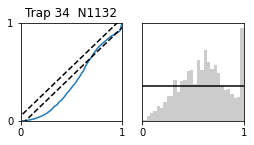

450 951103632 951109338


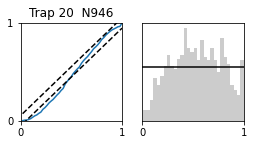

451 951103632 951109329


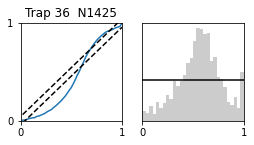

552 951103704 951108540


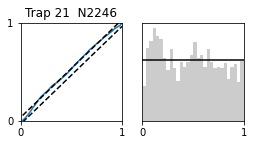

556 951103704 951108867


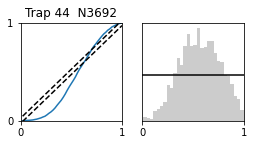

562 951103704 951109137


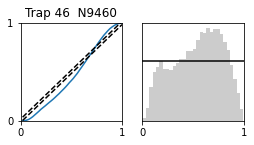

565 951103704 951109191


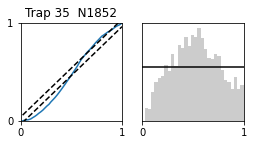

567 951103704 951109299


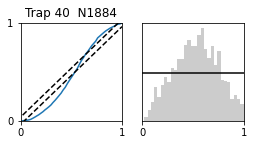

570 951103704 951109338


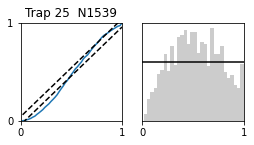

571 951103704 951109329


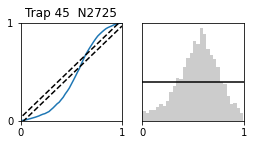

600 951104031 951108540


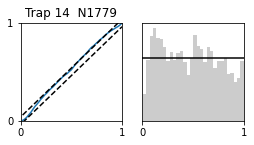

604 951104031 951108867


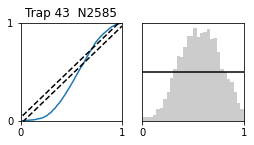

610 951104031 951109137


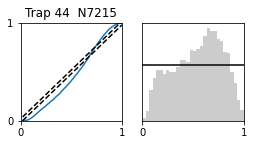

613 951104031 951109191


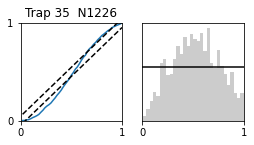

615 951104031 951109299


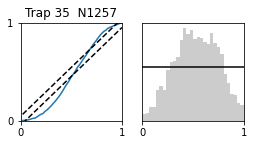

618 951104031 951109338


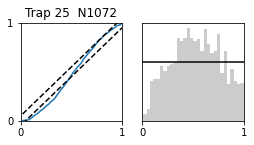

619 951104031 951109329


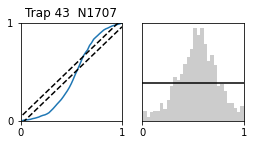

In [2006]:
u_list_dict = model.ks_test(spike_times, trial_window, group_model_pars, filter_membership_CD, selected_trial_ids[:], verbose=False)


In [2007]:
file_path = model_dir + f'CD_ks_test_u_list_dict_x3_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
util.save_variable(file_path, u_list_dict)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/CD_ks_test_u_list_dict_x3_20211123_213246.pkl


#### Plot all KS plots together.

In [2100]:
model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/'
# file_path = model_dir + 'CD_ks_test_u_list_dict_x3_20211123_213246.pkl'
file_path = model_dir + 'CD_ks_test_u_list_dict_20211123_144356.pkl'
u_list_dict_0 = util.load_variable(file_path)
file_path = model_dir + 'DE_ks_test_u_list_dict_20211123_192039.pkl'
u_list_dict_1 = util.load_variable(file_path)
u_list_dict = z = {**u_list_dict_0, **u_list_dict_1}

save figure: D:/Brain_Network/Output/fig/CD_DE_condition19_joint_fit_fixed_portion_11122021_KS.pdf


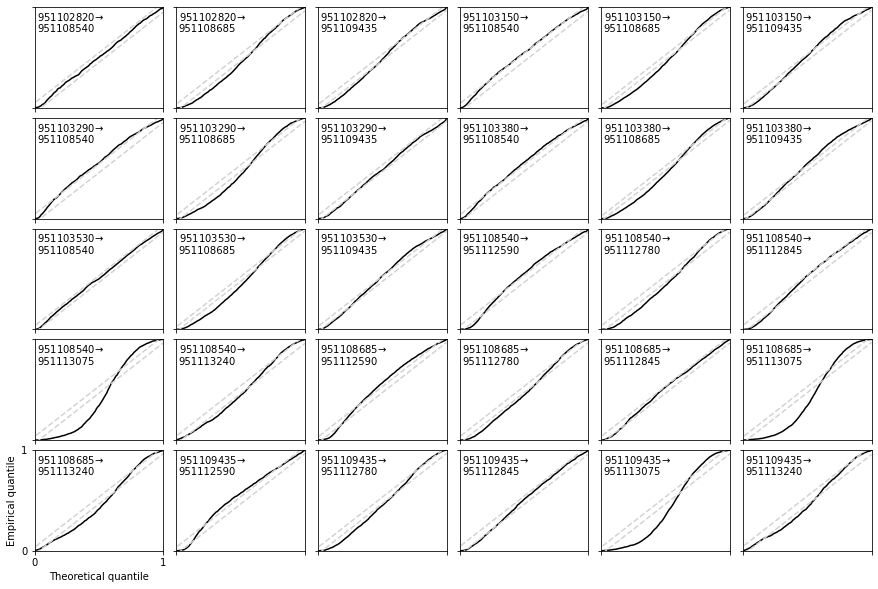

In [2102]:
file_path = project_dir + 'Output/fig/CD_DE_condition19_joint_fit_fixed_portion_11122021_KS.pdf'
model.plot_ks_u_list_dict(u_list_dict, test_size=0.01, file_path=file_path)

##### Debugging some errors.  951113075, 951113175 are weird. only one exception.
951109435 951113075

951108685 951113075

951108540 951113075

In [ ]:
u_list = u_list_dict[(951108685, 951108867)]
u_list = u_list[u_list > 0]
CI_trap, mcdf, ecdf, CI_up, CI_dn = jitter.JitterTool.check_ks(u_list, test_size=0.01, bin_width=0.02, verbose=True)

layers 2, nodes 1, trials 285
meanFR 9.219	meanISI 13.658


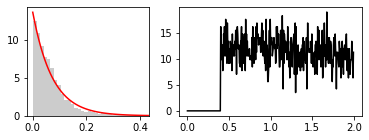

layers 2, nodes 1, trials 285
meanFR 7.337	meanISI 13.37


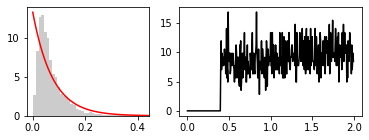

In [2053]:
spike_times_x = spike_times.loc[951108685,:].tolist()
spike_times_y = spike_times.loc[951108867,:].tolist()
jittertool.spike_times_statistics(spike_times_x, trial_length, verbose=True)
jittertool.spike_times_statistics(spike_times_y, trial_length, verbose=True)

In [2054]:
# model_par = {'filter_type': 'square', 'filter_length': 0.01,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.06,
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par = {'filter_type': 'none',
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.06,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
# model_par = {'filter_type': 'none',
#              'append_nuisance': ['const',],
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
# model_par = {'filter_type': 'bspline', 'num_knots': 5, 'knot_space_par': 0.1, 'filter_length': 0.4, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.06,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x[:], spike_times_y[:], [0, trial_length], model_par, verbose=True)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par, generator_par, ylim=[-10,10])

num_trials 285
X.shape (4182, 2), basis_integral.shape (2, 1),beta.shape(2, 1)
  5%|███                                                          | 5/100 [00:00<00:00, 1252.48it/s]
gradient [-1.40994457e-05  4.99124144e-04]
num itr 5 [[-4171.97364895]] 1.870969451728266e-07
beta [7.33684209 0.08876699]
none filter type.


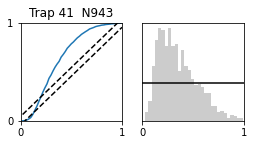

In [2055]:
model_par_ks_test = jittertool.ks_test(
        spike_times_x[:50], spike_times_y[:50], trial_window, model_par_hat, dt=0.001, test_size=0.05, verbose=True)
